<a href="https://colab.research.google.com/github/shriman/attraqt_movie_recommendation/blob/main/Attraqt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install dependencies here

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install scikit-surprise

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# test runtime config
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


# Imports

In [3]:
import os
import seaborn as sns
from os import path
import pandas as pd
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval

from surprise import Dataset, SVD, Reader
from surprise.model_selection import cross_validate

QUANTILE = 0.95

data_path = '/content/drive/My Drive/Colab Notebooks/Attraqt'
output_path = '/content/drive/My Drive/Colab Notebooks/Attraqt/outputs'

# Some helper functions

In [4]:
def get_source_filename(data_path, filename, suffix=None):
    if suffix:
        return os.path.join(data_path, filename + '.' + suffix)
    
    return os.path.join(data_path, filename + '.csv' )

movies_metadata_fname = get_source_filename(data_path, 'movies_metadata')
ratings_fname = get_source_filename(data_path, 'ratings')
evaluation_ratings_fname = get_source_filename(data_path, 'evaluation_ratings')
test_predictions_fname = get_source_filename(data_path, 'test')
print(movies_metadata_fname)

# output_path = get_source_filename(data_path, 'predictions')
print(output_path)


/content/drive/My Drive/Colab Notebooks/Attraqt/movies_metadata.csv
/content/drive/My Drive/Colab Notebooks/Attraqt/outputs


# Read data

In [5]:
movies_metadata_df= pd.read_csv(movies_metadata_fname, ',', low_memory=False)
print(movies_metadata_df.shape)
movies_metadata_df.head()

(45466, 24)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [6]:
ratings_df = pd.read_csv(ratings_fname, ',', low_memory=False)
print(ratings_df.shape)
ratings_df.head()

(20824175, 4)


,userId,movieId,rating,timestamp
0,1,81834,5.0,1425942133
1,1,112552,5.0,1425941336
2,1,98809,0.5,1425942640
3,1,99114,4.0,1425941667
4,1,858,5.0,1425941523


In [7]:
ratings_df['rating'].unique()

array([5. , 0.5, 4. , 2.5, 4.5, 1. , 3. , 2. , 3.5, 1.5])

# Data exploration 

In [8]:
movies_metadata_df.dtypes

adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                        object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
dtype: object

In [9]:
movies_metadata_df.loc[movies_metadata_df['id'].str.contains('-')]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
19730,- Written by Ørnås,0.065736,/ff9qCepilowshEtG2GYWwzt2bs4.jpg,"[{'name': 'Carousel Productions', 'id': 11176}...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",1997-08-20,0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Midnight Man,False,6.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29503,Rune Balot goes to a casino connected to the ...,1.931659,/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg,"[{'name': 'Aniplex', 'id': 2883}, {'name': 'Go...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-09-29,0,68.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,NaN,Mardock Scramble: The Third Exhaust,False,7.0,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35587,Avalanche Sharks tells the story of a bikini ...,2.185485,/zaSf5OG7V8X8gqFvly88zDdRm46.jpg,"[{'name': 'Odyssey Media', 'id': 17161}, {'nam...","[{'iso_3166_1': 'CA', 'name': 'Canada'}]",2014-01-01,0,82.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Beware Of Frost Bites,Avalanche Sharks,False,4.3,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
movies_metadata_df['id'] = movies_metadata_df['id'].str.replace('-', '')

In [11]:
movies_metadata_df.loc[movies_metadata_df['id'].str.contains('-')]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count


In [12]:
movies_metadata_df['id'] = movies_metadata_df['id'].astype(int)

In [13]:
movies_metadata_df.isnull().sum()

adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64

In [14]:
movies_metadata_df.loc[movies_metadata_df['vote_count'].isna()]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
19729,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,82663,tt0113002,en,Midnight Man,British soldiers force a recently captured IRA...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19730,- Written by Ørnås,0.065736,/ff9qCepilowshEtG2GYWwzt2bs4.jpg,"[{'name': 'Carousel Productions', 'id': 11176}...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",19970820,0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Midnight Man,False,6.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29502,False,"{'id': 122661, 'name': 'Mardock Scramble Colle...",0,"[{'id': 16, 'name': 'Animation'}, {'id': 878, ...",http://m-scramble.jp/exhaust/,122662,tt2423504,ja,マルドゥック・スクランブル 排気,Third film of the Mardock Scramble series.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29503,Rune Balot goes to a casino connected to the ...,1.931659,/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg,"[{'name': 'Aniplex', 'id': 2883}, {'name': 'Go...","[{'iso_3166_1': 'US', 'name': 'United States o...",20120929,0,68.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,NaN,Mardock Scramble: The Third Exhaust,False,7.0,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35586,False,NaN,0,"[{'id': 10770, 'name': 'TV Movie'}, {'id': 28,...",NaN,249260,tt2622826,en,Avalanche Sharks,A group of skiers are terrorized during spring...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35587,Avalanche Sharks tells the story of a bikini ...,2.185485,/zaSf5OG7V8X8gqFvly88zDdRm46.jpg,"[{'name': 'Odyssey Media', 'id': 17161}, {'nam...","[{'iso_3166_1': 'CA', 'name': 'Canada'}]",20140101,0,82.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Beware Of Frost Bites,Avalanche Sharks,False,4.3,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
ratings_df.loc[ratings_df['movieId'].isin(movies_metadata_df.loc[movies_metadata_df['vote_count'].isna()]['id'])]

,userId,movieId,rating,timestamp


**Drop rows in movies metadata where the votecount is nan**

In [16]:
movies_metadata_df = movies_metadata_df[movies_metadata_df['vote_count'].notna()]
movies_metadata_df.loc[movies_metadata_df['vote_count'].isna()]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count


In [17]:
movies_metadata_df.isnull().sum()

adult                        0
belongs_to_collection    40970
budget                       0
genres                       0
homepage                 37682
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   0
poster_path                383
production_companies         0
production_countries         0
release_date                84
revenue                      0
runtime                    257
spoken_languages             0
status                      81
tagline                  25048
title                        0
video                        0
vote_average                 0
vote_count                   0
dtype: int64

2787965087.0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


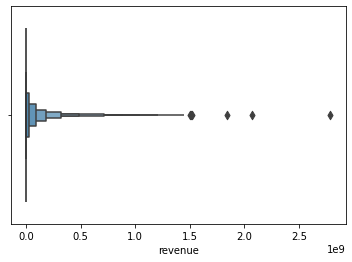

In [18]:
print(max(movies_metadata_df['revenue']))
sns.boxenplot(movies_metadata_df['revenue'])

**simplify the data set and remove dicitonaries**

In [19]:
movies_metadata_df['genres'] = movies_metadata_df['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
movies_metadata_df['spoken_languages'] = movies_metadata_df['spoken_languages'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
movies_metadata_df['year'] = pd.to_datetime(movies_metadata_df['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else 0)

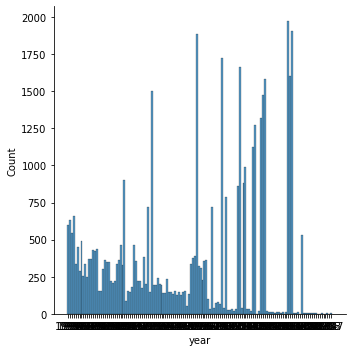

In [20]:
sns.displot(movies_metadata_df['year'])

**Remove nan from text variables**

In [19]:
movies_metadata_df['tagline'] = movies_metadata_df['tagline'].fillna('')
movies_metadata_df['overview'] = movies_metadata_df['overview'].fillna('')

In [22]:
movies_metadata_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,[English],Released,,Toy Story,False,7.7,5415.0,1995
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[English, Français]",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,[English],Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,[English],Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,[English],Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995


In [23]:
movies_metadata_df.isnull().sum()

adult                        0
belongs_to_collection    40970
budget                       0
genres                       0
homepage                 37682
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                     0
popularity                   0
poster_path                383
production_companies         0
production_countries         0
release_date                84
revenue                      0
runtime                    257
spoken_languages             0
status                      81
tagline                      0
title                        0
video                        0
vote_average                 0
vote_count                   0
year                         0
dtype: int64

In [24]:
movies_metadata_df.describe()

,id,revenue,runtime,vote_average,vote_count
count,45460.00000,4.546000e+04,45203.000000,45460.000000,45460.000000
mean,108357.07004,1.120935e+07,94.128199,5.618207,109.897338
std,112462.43383,6.433225e+07,38.407810,1.924216,491.310374
min,2.00000,0.000000e+00,0.000000,0.000000,0.000000
25%,26448.50000,0.000000e+00,85.000000,5.000000,3.000000
50%,59999.00000,0.000000e+00,95.000000,6.000000,10.000000
75%,157324.00000,0.000000e+00,107.000000,6.800000,34.000000
max,469172.00000,2.787965e+09,1256.000000,10.000000,14075.000000


# Basic recommender

Build a chart based recommender, i.e recommend the top n movies in each genre.

This reocommender is based on getting the maximum weighted rank for a movie, based on the vote average and vote counts.
To get the weighted rank of the movie, I use the IMDB weighted rating formula

```
weighted rating (WR) =  (v/(v+m))*R  + (m/(v+m))*C
```
where: 
* m = the minimum votes required to be listed in the chart
* v = number of votes for the movie (**vote_count**)
* C = the mean vote across the whole dataset
* R = the average rating of the movie (**vote_average**)




In [25]:
vote_counts = movies_metadata_df['vote_count'].astype('int')
vote_averages = movies_metadata_df['vote_average'].astype('int')

In [26]:
vote_averages.head()

0    7
1    6
2    6
3    6
4    5
Name: vote_average, dtype: int64

In [27]:
mean_vote_average = vote_averages.mean()
print('The Mean of vote_averages is: ', mean_vote_average)
minimum_vote_count = vote_counts.quantile(QUANTILE)
print('The minimum vote count for a movie to consider= ',minimum_vote_count)

The Mean of vote_averages is:  5.244896612406511
The minimum vote count for a movie to consider=  434.0


Thus for a movie to appear in the result of the basic recommender, it should have atleast 434 votes.

In [28]:
movies_with_vote_count = movies_metadata_df[(movies_metadata_df['vote_count'] >= minimum_vote_count) & (movies_metadata_df['vote_count'].notnull()) & (movies_metadata_df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
movies_with_vote_count['vote_count'] = movies_with_vote_count['vote_count'].astype('int')
movies_with_vote_count['vote_average'] = movies_with_vote_count['vote_average'].astype('int')
print('The filtered movies dataset for the basic recommender has shape: ',movies_with_vote_count.shape)

The filtered movies dataset for the basic recommender has shape:  (2274, 6)


In [29]:
def weighted_rating(x):
    vote_count = x['vote_count']
    vote_average = x['vote_average']
    return (vote_count/( vote_count + minimum_vote_count) * vote_average) + (minimum_vote_count/(minimum_vote_count + vote_count) * mean_vote_average)

In [30]:
movies_with_vote_count['weighted_rating'] = movies_with_vote_count.apply(weighted_rating, axis=1)
movies_with_vote_count = movies_with_vote_count.sort_values('weighted_rating', ascending=False).head(250)

In [31]:
movies_with_vote_count.head()

,title,year,vote_count,vote_average,popularity,genres,weighted_rating
15480,Inception,2010,14075,8,29.108149,"[Action, Thriller, Science Fiction, Mystery, A...",7.917588
12481,The Dark Knight,2008,12269,8,123.167259,"[Drama, Action, Crime, Thriller]",7.905871
22879,Interstellar,2014,11187,8,32.213481,"[Adventure, Drama, Science Fiction]",7.897107
2843,Fight Club,1999,9678,8,63.869599,[Drama],7.881753
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.070725,"[Adventure, Fantasy, Action]",7.871787


**Observations:**
Personally I like Inception, so no wonder that it has the highest weighted rating, and also the movies which follow are pretty interesting ones. But, this recommender will only produce results for top n movies in the whole dataset and nothing more. As a next logical step, let's see what are the top movies in each **genre**.

# Genre based movie recommender (top-K movies)

In [32]:
movies_genres = movies_metadata_df.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
movies_genres.name = 'genre'
movies_genres

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


0        Animation
0           Comedy
0           Family
1        Adventure
1          Fantasy
           ...    
45461       Family
45462        Drama
45463       Action
45463        Drama
45463     Thriller
Name: genre, Length: 91085, dtype: object

In [33]:
movies_metadata_with_genres = movies_metadata_df.join(movies_genres)
print(movies_metadata_with_genres.shape)
movies_metadata_with_genres.head()

(93527, 26)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year,genre
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,[English],Released,,Toy Story,False,7.7,5415.0,1995,Animation
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,[English],Released,,Toy Story,False,7.7,5415.0,1995,Comedy
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,[English],Released,,Toy Story,False,7.7,5415.0,1995,Family
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[English, Français]",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,Adventure
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[English, Français]",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,Fantasy


In [34]:
movies_metadata_with_genres_df = movies_metadata_df.drop('genres', axis=1).join(movies_genres)

In [35]:
movies_metadata_with_genres_df.head()

,adult,belongs_to_collection,budget,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year,genre
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,[English],Released,,Toy Story,False,7.7,5415.0,1995,Animation
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,[English],Released,,Toy Story,False,7.7,5415.0,1995,Comedy
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,[English],Released,,Toy Story,False,7.7,5415.0,1995,Family
1,False,NaN,65000000,NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[English, Français]",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,Adventure
1,False,NaN,65000000,NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[English, Français]",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,Fantasy


In [36]:
movies_metadata_with_genres_df.genre.unique()

array(['Animation', 'Comedy', 'Family', 'Adventure', 'Fantasy', 'Romance',
       'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'History',
       'Science Fiction', 'Mystery', 'War', 'Foreign', nan, 'Music',
       'Documentary', 'Western', 'TV Movie'], dtype=object)

In [37]:
movies_metadata_with_genres_df = movies_metadata_with_genres_df[movies_metadata_with_genres_df['genre'].notna()]
movies_metadata_with_genres_df.head()

,adult,belongs_to_collection,budget,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year,genre
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,[English],Released,,Toy Story,False,7.7,5415.0,1995,Animation
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,[English],Released,,Toy Story,False,7.7,5415.0,1995,Comedy
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,[English],Released,,Toy Story,False,7.7,5415.0,1995,Family
1,False,NaN,65000000,NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[English, Français]",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,Adventure
1,False,NaN,65000000,NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[English, Français]",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,Fantasy


In [38]:
def get_top_recommendations_for_genre(genre, percentile=QUANTILE):
    # get weighted rank of movies based on the genre
    movies_df = movies_metadata_with_genres_df[movies_metadata_with_genres_df['genre'] == genre]
    vote_counts = movies_df[movies_df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies_df[movies_df['vote_average'].notnull()]['vote_average'].astype('int')
    mean_vote_average = vote_averages.mean()
    minimum_vote_count = vote_counts.quantile(percentile)
    
    filtered_df = movies_df[(movies_df['vote_count'] >= minimum_vote_count) & (movies_df['vote_count'].notnull()) & (movies_df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    filtered_df['vote_count'] = filtered_df['vote_count'].astype('int')
    filtered_df['vote_average'] = filtered_df['vote_average'].astype('int')
    
    filtered_df['weighted_rating'] = filtered_df.apply(lambda x: (x['vote_count']/(x['vote_count']+minimum_vote_count) * x['vote_average']) + (minimum_vote_count/(minimum_vote_count+x['vote_count']) * mean_vote_average), axis=1)
    filtered_df = filtered_df.sort_values('weighted_rating', ascending=False).head(250)
    
    return filtered_df

In [39]:
get_top_recommendations_for_genre('Comedy').head(10)

,title,year,vote_count,vote_average,popularity,weighted_rating
351,Forrest Gump,1994,8147,8,48.307194,7.843994
1225,Back to the Future,1985,6239,8,25.778509,7.799850
18465,The Intouchables,2011,5410,8,16.086919,7.771794
22841,The Grand Budapest Hotel,2014,4644,8,14.442048,7.737837
2211,Life Is Beautiful,1997,3643,8,39.39497,7.674556
10309,Dilwale Dulhania Le Jayenge,1995,661,9,34.457024,7.408901
732,Dr. Strangelove or: How I Learned to Stop Worr...,1964,1472,8,9.80398,7.316986
3342,Modern Times,1936,881,8,8.159556,7.025524
883,Some Like It Hot,1959,835,8,11.845107,6.992045
26564,Deadpool,2016,11444,7,187.860492,6.929222


In [40]:
get_top_recommendations_for_genre('Adventure').head()

,title,year,vote_count,vote_average,popularity,weighted_rating
15480,Inception,2010,14075,8,29.108149,7.589256
22879,Interstellar,2014,11187,8,32.213481,7.502559
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.070725,7.402307
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.324358,7.365179
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.423537,7.328542


# Metadata based recommender / Content based filtering

* The above recommender was great when we wanted to search movies only for a 
single genre.
* But, what aboout the case, where we want to have more presonalized recommendation?
* In this case, seems like **tagline and overview**, could give us some insights about the movie and could be worth trying to see the recommendations. 

In [41]:
movies_metadata_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,[English],Released,,Toy Story,False,7.7,5415.0,1995
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[English, Français]",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,[English],Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,[English],Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,[English],Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995


In [42]:
movies_metadata_df['movie_description'] = movies_metadata_df['overview'] + movies_metadata_df['tagline']

In [43]:
movies_metadata_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year,movie_description
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,[English],Released,,Toy Story,False,7.7,5415.0,1995,"Led by Woody, Andy's toys live happily in his ..."
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[English, Français]",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,When siblings Judy and Peter discover an encha...
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,[English],Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995,A family wedding reignites the ancient feud be...
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,[English],Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995,"Cheated on, mistreated and stepped on, the wom..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,[English],Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995,Just when George Banks has recovered from his ...


The Tf-idf vectorizer from sklearn is a powerful library to ompute word counts, IDF values and Tf-idf scores all using the same dataset.

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(movies_metadata_df['movie_description'])

Now that we have the vectorized data, we would used cosine similarity to calculate the similarity between two movies based on the movie description
for more info on consine similarity please refer  [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html)

Since, we have already computed the tf-idf matrix, the cosine similarity can be directly computed using scalar product of the td-idf matrix.

In [49]:
cosine_similarity = linear_kernel(tfidf_matrix, tfidf_matrix)

In [51]:
cosine_similarity.shape

(45460, 45460)

In [62]:
cosine_similarity.dtype

dtype('float64')

In [21]:
cosine_similarity_output_filename = get_source_filename(output_path, 'cosine_similarity', '.npy')
print(cosine_similarity_output_filename)
# np.save(cosine_similarity_output_filename, cosine_similarity)

/content/drive/My Drive/Colab Notebooks/Attraqt/outputs/cosine_similarity..npy


In [22]:
# read saved cosine similarity matrix
cosine_similarity = np.load(cosine_similarity_output_filename)

In [52]:
# get a data frame of movies and ids
titles = movies_metadata_df['title']
indices = pd.Series(movies_metadata_df.index, index=movies_metadata_df['title'])

In [53]:
indices.head()

title
Toy Story                      0
Jumanji                        1
Grumpier Old Men               2
Waiting to Exhale              3
Father of the Bride Part II    4
dtype: int64

In [54]:
def get_text_based_recommendation(title , number_of_movies):
    idx = indices[title]
    similarity_scores = list(enumerate(cosine_similarity[idx]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    similarity_scores = similarity_scores[1:number_of_movies]
    movie_indices = [i[0] for i in similarity_scores]
    return pd.DataFrame(titles.iloc[movie_indices])

In [70]:
get_text_based_recommendation('Inception', 10).head()

,title
44314,III
7460,Cypher
159,Crumb
10908,Renaissance
9095,The Brave
